In [2]:
import math
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('AAPL.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-13,35.477501,35.595001,35.262501,35.262501,33.293438,71291600
1,2017-04-17,35.369999,35.470001,35.217499,35.457500,33.477551,66328400
2,2017-04-18,35.352501,35.509998,35.277500,35.299999,33.328842,58790000
3,2017-04-19,35.470001,35.500000,35.112499,35.169998,33.206097,69313600
4,2017-04-20,35.305000,35.730000,35.290001,35.610001,33.621532,93278400
...,...,...,...,...,...,...,...
1254,2022-04-06,172.360001,173.630005,170.130005,171.830002,171.830002,89058800
1255,2022-04-07,171.160004,173.360001,169.850006,172.139999,172.139999,77594700
1256,2022-04-08,171.779999,171.779999,169.199997,170.089996,170.089996,76515900
1257,2022-04-11,168.710007,169.029999,165.500000,165.750000,165.750000,72246700


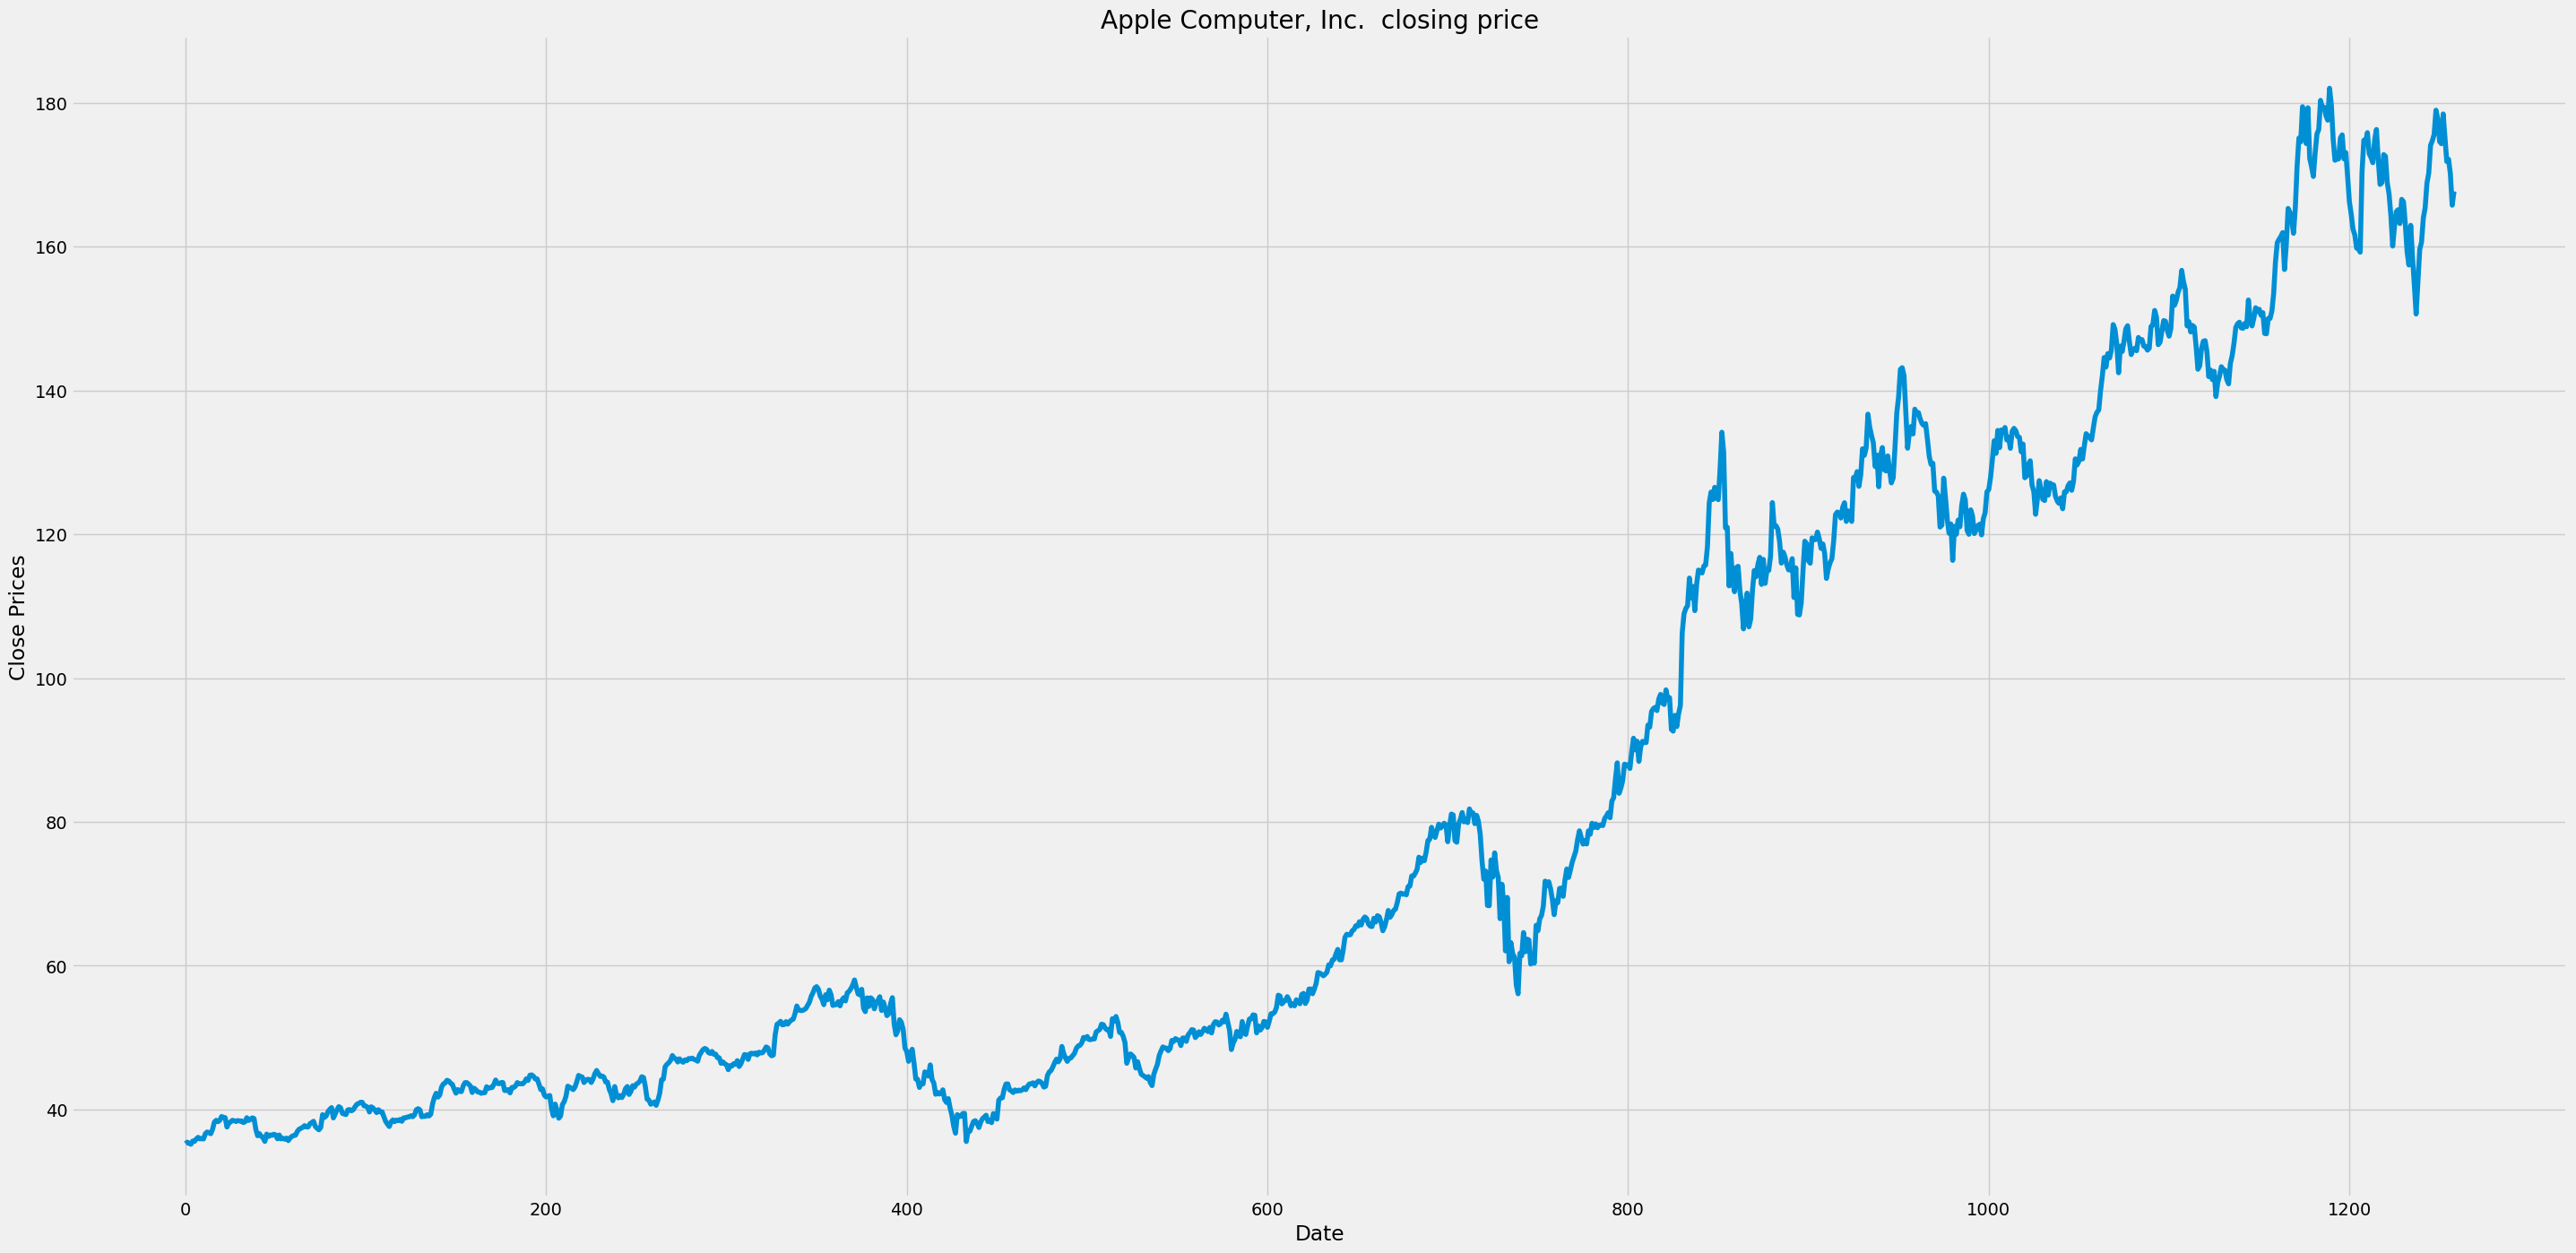

In [4]:
#Visualizing the whole data
plt.figure(figsize=(32,16))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Apple Computer, Inc.  closing price')
plt.show()

<Axes: ylabel='Density'>

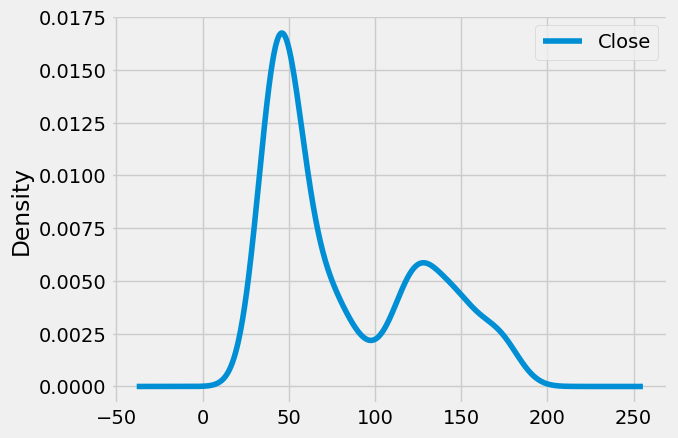

In [5]:
df_close=df.filter(['Close'])
df_close.plot(kind='kde')

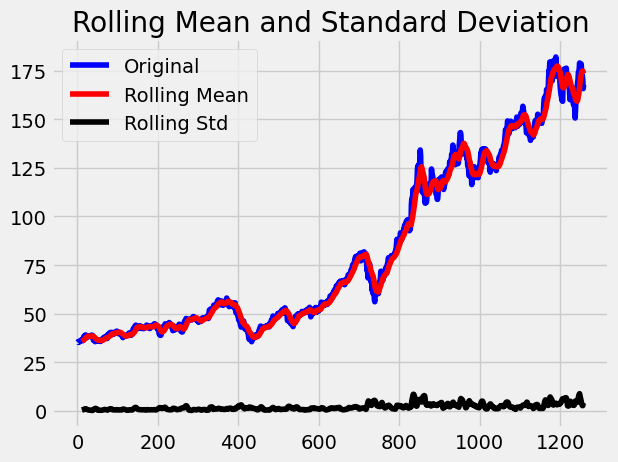

Results of dickey fuller test
Test Statistics                   0.429503
p-value                           0.982565
No. of lags used                 20.000000
Number of observations used    1238.000000
critical value (1%)              -3.435643
critical value (5%)              -2.863877
critical value (10%)             -2.568014
dtype: float64


In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

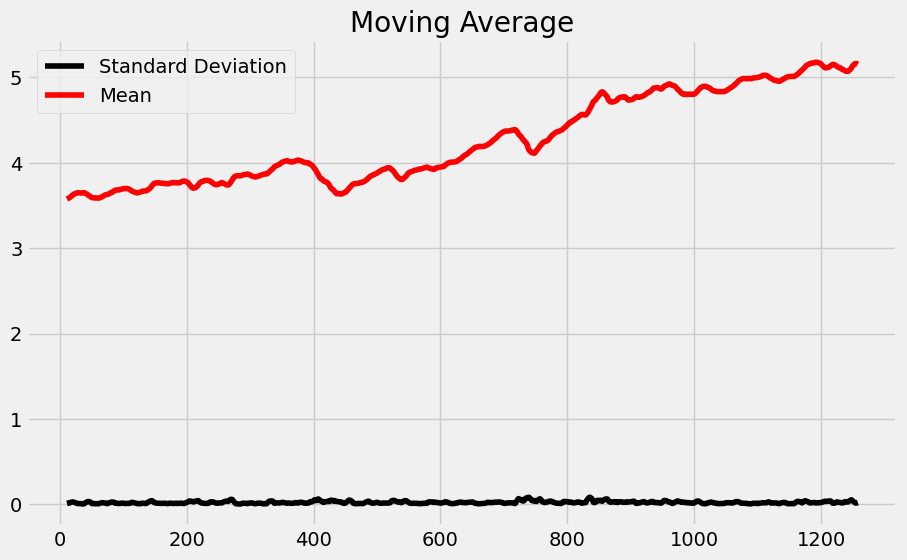

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

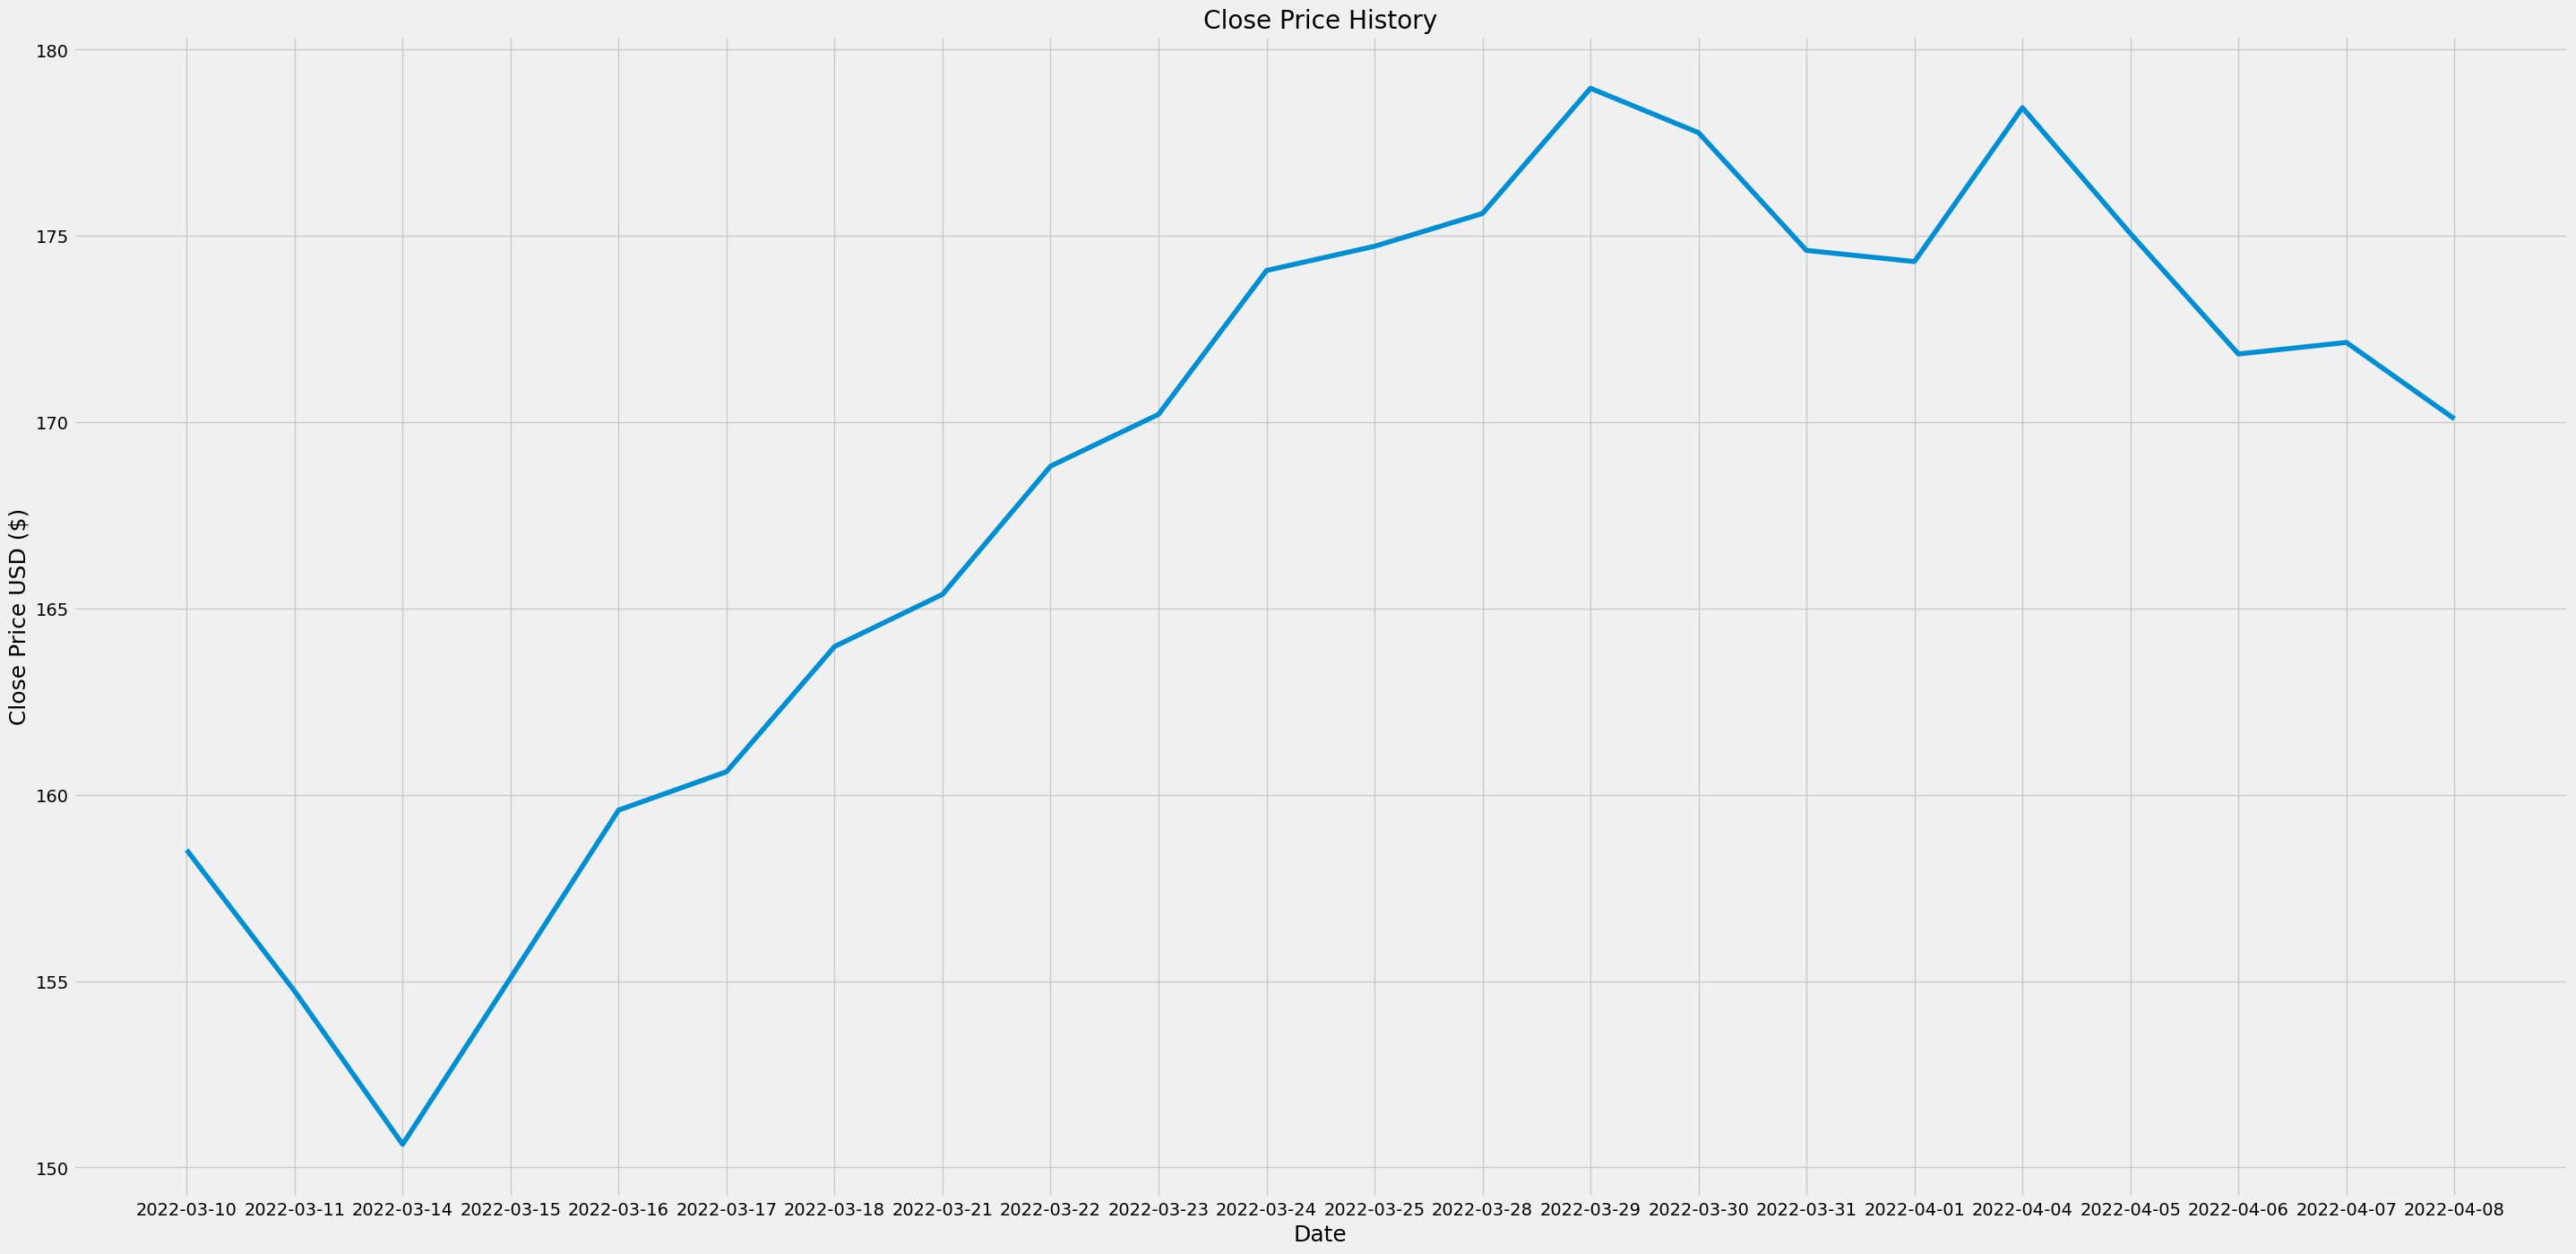

In [8]:
#Visualizing just the past month
df_2 = df.iloc[1235:1257]
plt.figure(figsize=(32,16))
plt.title('Close Price History')
plt.plot(df_2['Date'], df_2['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show

In [9]:
import plotly.graph_objects as go

In [10]:
trace1 = {
    'x': df.Date,
    'open': df.Open,
    'close': df.Close,
    'high': df.High,
    'low': df.Low,
    'type': 'candlestick',
    'name': 'AAPL',
    'showlegend': True
}
data = [trace1]
# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'Apple(AAPL) Moving Averages',
        'font': {
            'size': 15
        }
    }
})
fig = go.Figure(data=data, layout=layout)
fig.write_html("Apple(AAPL) Moving Averages")
fig.show()

In [11]:
# Calculate and define moving average of 30 periods
avg_30 = df.Close.rolling(window=30, min_periods=1).mean()

# Calculate and define moving average of 50 periods
avg_50 = df.Close.rolling(window=50, min_periods=1).mean()

trace2 = {
    'x': df.Date,
    'y': avg_30,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'blue'
            },
    'name': 'Moving Average of 30 periods'
}

trace3 = {
    'x': df.Date,
    'y': avg_50,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'red'
    },
    'name': 'Moving Average of 50 periods'
}
data = [trace1, trace2, trace3]
# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'Apple(AAPL) Moving Averages',
        'font': {
            'size': 15
        }
    }
})
fig = go.Figure(data=data, layout=layout)
fig.write_html("Apple(AAPL) Moving Averages.html")
fig.show()


In [12]:
#Create a new df with only close values
data = df.filter(['Close'])
dataset = data.values

In [13]:
#Get the number of rows to train the model
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1008

In [14]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[6.29957790e-04],
       [1.95792704e-03],
       [8.85324180e-04],
       ...,
       [9.18823214e-01],
       [8.89267261e-01],
       [9.02274644e-01]])

In [15]:
#Creating Training Dataset
train_data = scaled_data[0:training_data_len, :]

In [16]:
#splitting
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()

[array([0.00062996, 0.00195793, 0.00088532, 0.        , 0.00299648,
       0.00270705, 0.00503951, 0.00655477, 0.0051076 , 0.00529488,
       0.00505652, 0.01004496, 0.01162831, 0.01086217, 0.00995983,
       0.014097  , 0.02099224, 0.02266074, 0.02141788, 0.02259263,
       0.02625309, 0.02557206, 0.02518048, 0.01629326, 0.02019205,
       0.02107737, 0.02266074, 0.02233726, 0.02155408, 0.02245642,
       0.02201377, 0.02211592, 0.02056661, 0.02128167, 0.02514643,
       0.02255857, 0.02344389, 0.02501022, 0.02436327, 0.01413103,
       0.00807002, 0.01006198, 0.00762737, 0.00614615, 0.00270705,
       0.00963635, 0.00737198, 0.00883616, 0.00842756, 0.0095342 ,
       0.00875105, 0.00519273, 0.00876806, 0.0051076 , 0.00568648,
       0.00480116, 0.00580565, 0.0034902 , 0.00595887, 0.0074571 ])]
[0.008257300631789033]



In [17]:
data_training=pd.DataFrame(data['Close'][0:int(len(data)*0.70)])
data_testing=pd.DataFrame(data['Close'][int(len(data)*0.70):int(len(df_close))])
print(data_training.shape)
print(data_testing.shape)

(881, 1)
(378, 1)


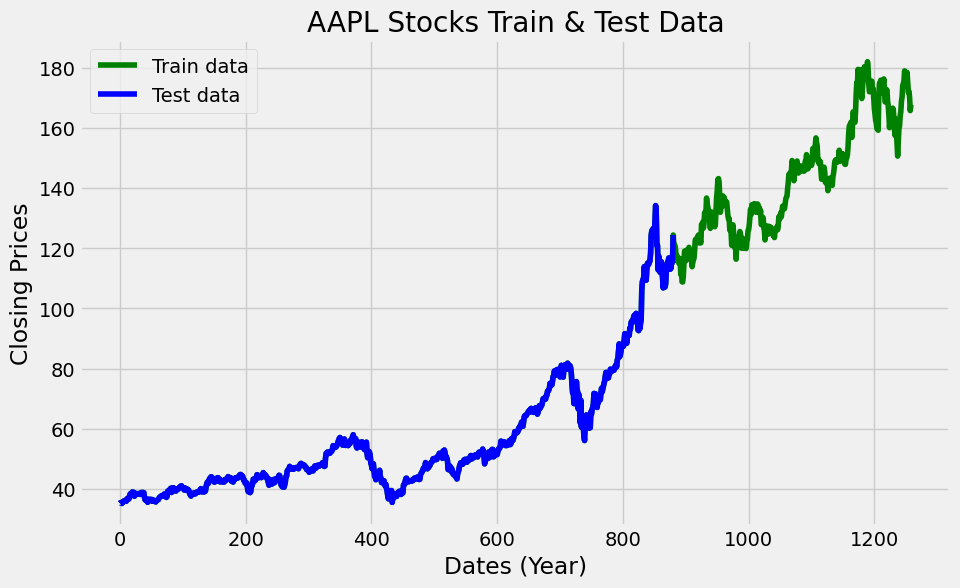

In [18]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('AAPL Stocks Train & Test Data')
plt.xlabel('Dates (Year)')
plt.ylabel('Closing Prices')
plt.plot(data ,'green', label='Train data')
plt.plot(data_training , 'blue', label='Test data')
plt.legend()

In [19]:
#convert to np
x_train, y_train = np.array(x_train), np.array(y_train)

x_train

array([[6.29957790e-04, 1.95792704e-03, 8.85324180e-04, ...,
        3.49020029e-03, 5.95886692e-03, 7.45710312e-03],
       [1.95792704e-03, 8.85324180e-04, 0.00000000e+00, ...,
        5.95886692e-03, 7.45710312e-03, 8.25730063e-03],
       [8.85324180e-04, 0.00000000e+00, 2.99647922e-03, ...,
        7.45710312e-03, 8.25730063e-03, 8.61483946e-03],
       ...,
       [6.38381966e-01, 6.26327996e-01, 6.31027008e-01, ...,
        6.48256640e-01, 6.66235385e-01, 6.54249584e-01],
       [6.26327996e-01, 6.31027008e-01, 6.59629549e-01, ...,
        6.66235385e-01, 6.54249584e-01, 6.75973829e-01],
       [6.31027008e-01, 6.59629549e-01, 6.92590568e-01, ...,
        6.54249584e-01, 6.75973829e-01, 6.59629549e-01]])

In [20]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(948, 60, 1)

In [21]:
#LSTM MODEL
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
model = Sequential()
model.add(LSTM(units=50,activation='relu',return_sequences=True,
               input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25)) 
model.add(Dense(1))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=25)

Epoch 1/25
948/948 [==============================] - 58s 51ms/step - loss: 3.2493e-04
Epoch 2/25
948/948 [==============================] - 43s 45ms/step - loss: 3.1458e-04
Epoch 3/25
948/948 [==============================] - 50s 52ms/step - loss: 2.9880e-04
Epoch 4/25
948/948 [==============================] - 52s 55ms/step - loss: 2.6857e-04
Epoch 5/25
948/948 [==============================] - 51s 54ms/step - loss: 2.5949e-04
Epoch 6/25
948/948 [==============================] - 60s 63ms/step - loss: 2.8860e-04
Epoch 7/25
948/948 [==============================] - 56s 59ms/step - loss: 2.8001e-04
Epoch 8/25
948/948 [==============================] - 55s 58ms/step - loss: 3.1929e-04
Epoch 9/25
948/948 [==============================] - 54s 57ms/step - loss: 3.4327e-04
Epoch 10/25
948/948 [==============================] - 50s 53ms/step - loss: 2.5272e-04
Epoch 11/25
948/948 [==============================] - 50s 53ms/step - loss: 2.6903e-04
Epoch 12/25
948/948 [====================

In [32]:
model.save('keras_model.keras')

In [33]:
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test = dataset[training_data_len:, : ]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [34]:
#convert to np
x_test = np.array(x_test)

In [35]:
#reshape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
#Get the models predicted value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 1s 39ms/step


In [37]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.0292527250237336

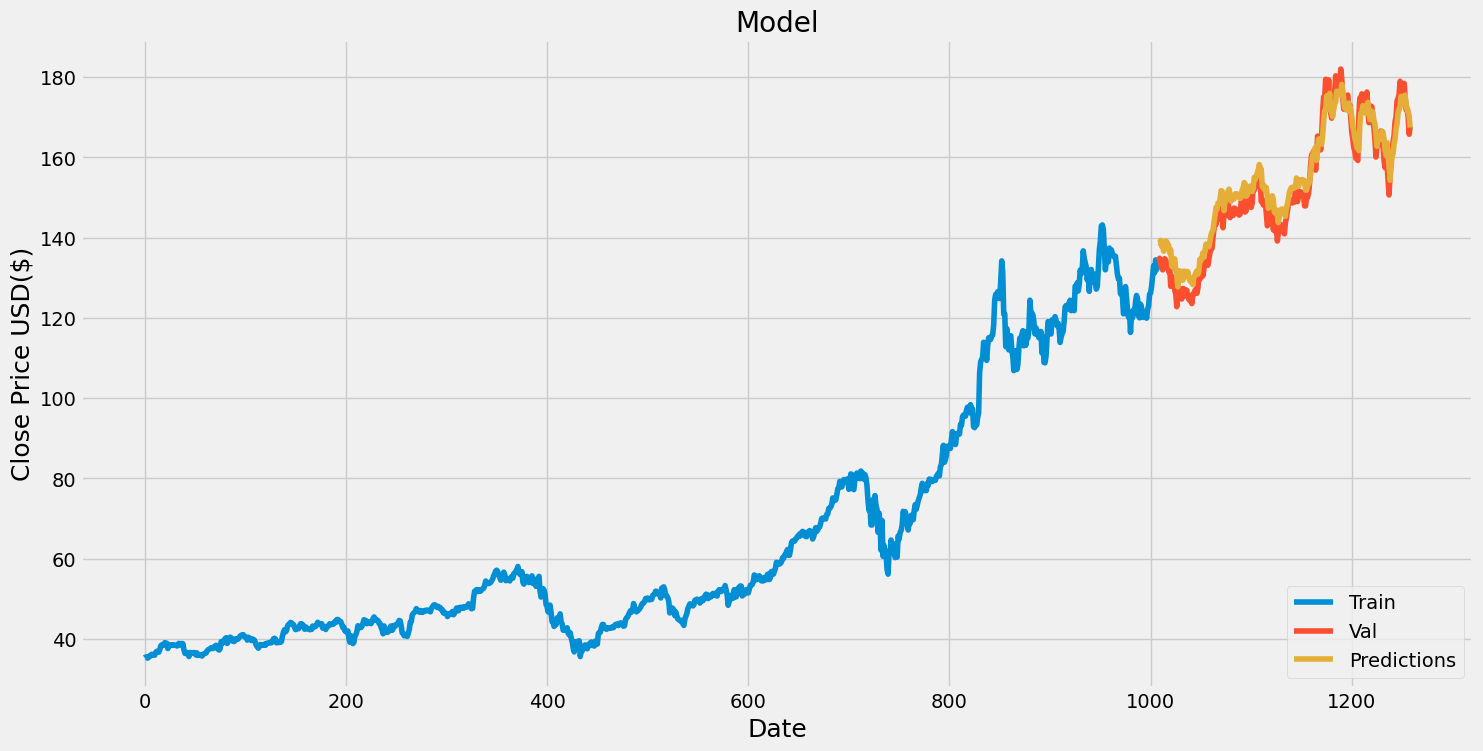

In [38]:
#Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize = (16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()